In [1]:
import numpy as np
import torch
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from pyhmc import hmc


In [9]:
import ot
def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)

# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)



# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
from tqdm import tqdm

In [6]:

Gauss_LL_mnist = []
Gauss_W2_mnist = []
for i in tqdm(range(1)):

    X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=i)


    gauss_cov = np.cov(X_train.reshape(-1, 784).T)
    top = (scs.multivariate_normal.logpdf(X_test.reshape(-1, 784), mean=np.zeros(784), cov=gauss_cov+1e-10*np.eye(784)).mean())
    bot = (scs.multivariate_normal.logpdf(X_test.reshape(-1, 784), mean=np.zeros(784), cov=np.eye(784)).mean())
    Gauss_LL_mnist.append(top-bot)
    sims_gauss = scs.multivariate_normal.rvs(mean=np.zeros(784), cov=gauss_cov+1e-10*np.eye(784), size=25)
    Gauss_W2_mnist.append(W2(X_test.reshape(-1,28*28).float(),torch.tensor(sims_gauss).reshape(-1,28*28).float()))

100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


In [7]:
np.mean(Gauss_LL_mnist), np.std(Gauss_LL_mnist),np.mean(Gauss_W2_mnist), np.std(Gauss_W2_mnist)

(126.42638961130842, 0.0, 37.04207, 0.0)

In [26]:
GGCNN_LL_mnist = [
197.11,
203.69,
220.88,
217.37,
164.36,
196.70,
168.83,
194.59,
221.96]






np.mean(GGCNN_LL_mnist), np.std(GGCNN_LL_mnist)


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(198.38777777777779, 19.72151773389652, nan, nan)

In [31]:
GGCNN_W2_mnist = []


for i in range(10):
    if i!=1:
        samples = np.load(f'final_mnist_GGCNN\logsumexpGGCNN_HM100burnin_N01_{i}_500epoch_samples_mnist.npy')
        GGCNN_W2_mnist.append(W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples).reshape(-1,28*28).float()))

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [41]:
(W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples).reshape(-1,28*28).float()))

tensor(36.1432)

In [32]:
np.mean(GGCNN_W2_mnist), np.std(GGCNN_W2_mnist)

(36.442356, 0.5050038)

# Vine

In [6]:
import pyvinecopulib as pv
import time 

In [7]:
U = scs.norm.cdf(X_train.reshape(-1,28*28))
U_test = scs.norm.cdf(X_test.reshape(-1,28*28))

In [8]:
n= U.shape[0]
d=2
scott_bdw = (n * (d + 2) / 4.)**(-1. / (d + 4))
scott_bdw

0.1793961523747216

In [26]:



start = time.time()
controls = pv.FitControlsVinecop(family_set=[pv.BicopFamily.tll],
                                                selection_criterion='mbic',
                                                nonparametric_method='constant', #KDE-copula
                                                nonparametric_mult=scott_bdw,
                                                trunc_lvl=10,
                                                threshold=0.05, # truntrunc_lvl=5,threshold=0.05 30K mnist -> 33mins train/sample/evals
                                                # threshold=0.05, # trunc_lvl=10,threshold=0.05 30K mnist -> 42mins train/sample/evals
                                                # threshold=0.05, # trunc_lvl=50,threshold=0.05 30K mnist -> 2h10 train/sample/evals
                                                # 140m trctrunc_lvl=5,threshold=0.05 30K mnist 184 LL
                                                num_threads = 8) # bandwidth
cop = pv.Vinecop(U, controls=controls)
print('fitted',time.time()-start)

time2 = time.time()
cop_sample = cop.simulate(25)
print('sims', time.time()-time2)

time3 = time.time()
cop_logpdf = cop.loglik(U_test)
print('-logpdf', time.time()-time3)
print(cop_logpdf/U_test.shape[0])

fitted 3074.4022586345673
sims 1.364948034286499
-logpdf 80.80408310890198
180.19220355653488


In [25]:
3425.947764158249/60

57.09912940263748

In [27]:
# save with numpy
np.save('copula_samples_mnist_t10.npy', cop_sample)

In [12]:
import matplotlib.pyplot as plt

In [13]:
def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

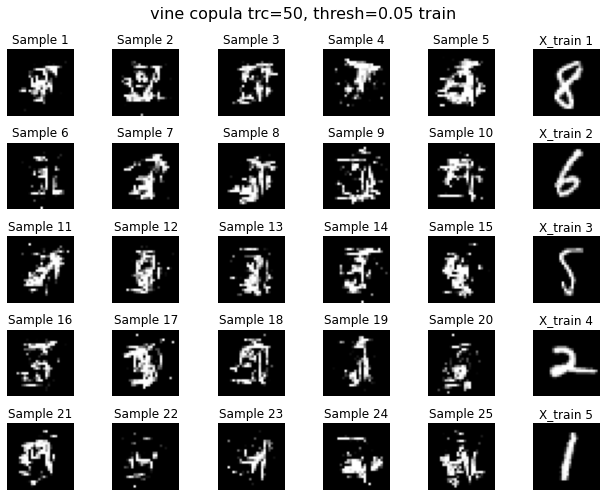

In [29]:
cop_sample_norm = scs.norm.ppf(cop_sample)

fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle(" vine copula trc=50, thresh=0.05 train ", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(cop_sample_norm[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[i]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()

In [28]:
W2(X_test.reshape(-1,28*28).float(),torch.tensor(cop_sample_norm[:25]).reshape(-1,28*28).float())

tensor(37.6602)

# IGC

In [6]:

    #### IGC model



    class SoftRank(nn.Module):
        """Differentiable ranking layer"""
        def __init__(self, alpha=1000.0):
            super(SoftRank, self).__init__()
            self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

        def forward(self, inputs):
            # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
            # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
            x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
            x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
            x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
            return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


    class IGC(nn.Module):
        
        def __init__(self, hidden_size=100, layers_number=2, output_size=2):
            super(IGC, self).__init__()
            self.dim_latent = 3 * output_size
            self.hidden_size = hidden_size
            self.layers_nuber = layers_number
            self.output_size = output_size
            self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
            self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
            self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
            self.marginal_cdfs = None
            self.ecdf_10e6_samples = None

        def forward_train(self, z):
            '''
            Input noise z with shape (M,dim_latent)\\
            Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
            '''
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y).unsqueeze(0)
            u = SoftRank()(y).squeeze(0)
            return u
            
        def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
            n = len(observations_y)
            m = len(simulations_Y)

            # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
            diff_Y_y = torch.pow(
                torch.norm(
                    (observations_y.unsqueeze(1) -
                    simulations_Y.unsqueeze(0)).float(),
                    dim=2,keepdim=True).reshape(-1,1),
                beta)

            # Second part |Y-Y'|. 2* because pdist counts only once.
            diff_Y_Y = 2 * torch.pow(
                nn.functional.pdist(simulations_Y),
                beta)
            Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
            return Energy


        def forward(self, n_samples):
            ''' 
            Function to sample from the copula, once training is done.

            Input: n_samples - number of samples to generate
            Output: torch.tensor of shape (n_samples, output_size) on copula space.
            '''
            with torch.no_grad():
                if self.marginal_cdfs is None:
                    self.marginal_cdfs = []
                    # sample 10^6 points from the latent space and compute empirical marginal cdfs
                    z = torch.randn(10**6, self.dim_latent)
                    y = torch.relu(self.linear_in(z))
                    for layer in range(self.layers_nuber):
                        y = torch.relu(self.linear(y))
                    y = self.linear_out(y) # samples used to approximate cdfs
                    for dim in range(y.shape[1]):
                        ecdf = ECDF(y[:, dim].numpy())
                        self.marginal_cdfs.append(ecdf)
                    self.ecdf_10e6_samples = y
                # sample the latent space and apply ecdfs
                z = torch.randn(n_samples, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y)
                for dim in range(y.shape[1]):
                    y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
                return y



In [37]:
from tqdm import tqdm

In [33]:
igc_cop_ = IGC(hidden_size=100, layers_number=5, output_size=28*28)
total_params = sum(p.numel() for p in igc_cop_.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 324584


In [30]:
# Calculate the number of parameters
igc_cop = IGC(hidden_size=100, layers_number=2, output_size=28*28)
total_params = sum(p.numel() for p in igc_cop.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 324584


In [42]:
from torchsummary import summary

summary(igc_cop, input_size=(1, 28, 28))  # Adjust input_size as needed

In [50]:
for seed in range(9):
    seed += 1
    # Split the data into training and testing sets (50/50 split)
    X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=seed)
    # make training data on 0-1 scale
    X_train_cop = torch.tensor(scs.norm.cdf(X_train.reshape(-1,28*28)),dtype=torch.float32).clip(1e-5,1-1e-5)
    
    # training loop
    igc_cop = IGC(hidden_size=100, layers_number=3, output_size=28*28)

    u_obs = X_train_cop

    optimizer = torch.optim.Adam(igc_cop.parameters())
    loss_hist = []

    for i in tqdm(range(501)):
        optimizer.zero_grad()
        u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
        loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
        if i % 100 == 0:
            print(loss.item())

    samples_cdf = igc_cop.forward_train(torch.randn((25, igc_cop.dim_latent)))
    print(seed)
    print((W2(X_test.reshape(-1,28*28).float(),torch.tensor(scs.norm.ppf(samples_cdf.detach().numpy())).float(),),'IGC'))

    torch.save(igc_cop.state_dict(), f'igc_cop_mnist_10runs_seed{seed}.pth')



  0%|          | 1/501 [00:01<09:06,  1.09s/it]

11.488859176635742


 20%|██        | 101/501 [01:42<07:26,  1.12s/it]

11.326433181762695


 40%|████      | 201/501 [03:24<05:14,  1.05s/it]

11.393627166748047


 60%|██████    | 301/501 [05:05<03:20,  1.00s/it]

11.326325416564941


 80%|████████  | 401/501 [06:48<01:39,  1.00it/s]

11.47313404083252


100%|██████████| 501/501 [08:28<00:00,  1.01s/it]

11.323182106018066
1


(tensor(36.0503), 'IGC')


  0%|          | 1/501 [00:00<08:18,  1.00it/s]

11.507871627807617


 20%|██        | 101/501 [01:39<06:33,  1.02it/s]

11.459611892700195


 40%|████      | 201/501 [03:19<04:57,  1.01it/s]

11.34811782836914


 60%|██████    | 301/501 [04:57<03:16,  1.02it/s]

11.423545837402344


 80%|████████  | 401/501 [06:40<01:39,  1.01it/s]

11.410325050354004


100%|██████████| 501/501 [08:18<00:00,  1.00it/s]

11.424661636352539
2



c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


(tensor(36.1236), 'IGC')


  0%|          | 1/501 [00:00<08:14,  1.01it/s]

11.437948226928711


 20%|██        | 101/501 [01:38<06:24,  1.04it/s]

11.46111011505127


 40%|████      | 201/501 [03:16<04:53,  1.02it/s]

11.37551212310791


 60%|██████    | 301/501 [04:54<03:15,  1.02it/s]

11.357294082641602


 80%|████████  | 401/501 [06:32<01:38,  1.01it/s]

11.389264106750488


100%|██████████| 501/501 [08:10<00:00,  1.02it/s]

11.344599723815918
3


(tensor(35.9470), 'IGC')


  0%|          | 1/501 [00:00<08:05,  1.03it/s]

11.483895301818848


 20%|██        | 101/501 [01:38<06:28,  1.03it/s]

11.426070213317871


 40%|████      | 201/501 [03:16<04:51,  1.03it/s]

11.443681716918945


 60%|██████    | 301/501 [04:54<03:16,  1.02it/s]

11.421318054199219


 80%|████████  | 401/501 [06:32<01:38,  1.01it/s]

11.405848503112793


100%|██████████| 501/501 [08:10<00:00,  1.02it/s]

11.38180160522461
4


(tensor(36.0018), 'IGC')


  0%|          | 1/501 [00:01<08:28,  1.02s/it]

11.376882553100586


 20%|██        | 101/501 [01:42<06:41,  1.00s/it]

11.34701156616211


 40%|████      | 201/501 [03:20<04:59,  1.00it/s]

11.430047035217285


 60%|██████    | 301/501 [05:01<03:13,  1.03it/s]

11.390410423278809


 80%|████████  | 401/501 [06:40<01:43,  1.03s/it]

11.308869361877441


100%|██████████| 501/501 [08:22<00:00,  1.00s/it]

11.437922477722168
5


(tensor(36.0666), 'IGC')


  0%|          | 1/501 [00:01<08:43,  1.05s/it]

11.512635231018066


 20%|██        | 101/501 [01:41<06:30,  1.02it/s]

11.479730606079102


 40%|████      | 201/501 [03:19<04:55,  1.02it/s]

11.371349334716797


 60%|██████    | 301/501 [04:57<03:15,  1.02it/s]

11.517054557800293


 80%|████████  | 401/501 [06:38<01:36,  1.04it/s]

11.411425590515137


100%|██████████| 501/501 [08:20<00:00,  1.00it/s]

11.41932487487793
6


(tensor(35.9763), 'IGC')


  0%|          | 1/501 [00:00<08:04,  1.03it/s]

11.436112403869629


 20%|██        | 101/501 [01:38<06:27,  1.03it/s]

11.3960542678833


 40%|████      | 201/501 [03:17<04:53,  1.02it/s]

11.338504791259766


 60%|██████    | 301/501 [04:55<03:14,  1.03it/s]

11.333251953125


 80%|████████  | 401/501 [06:32<01:36,  1.03it/s]

11.443769454956055


100%|██████████| 501/501 [08:13<00:00,  1.01it/s]

11.38141918182373
7


(tensor(35.9971), 'IGC')


  0%|          | 1/501 [00:00<08:11,  1.02it/s]

11.414690971374512


 20%|██        | 101/501 [01:38<06:32,  1.02it/s]

11.390527725219727


 40%|████      | 201/501 [03:20<04:59,  1.00it/s]

11.417322158813477


 60%|██████    | 301/501 [05:03<03:16,  1.02it/s]

11.38468074798584


 80%|████████  | 401/501 [06:47<01:36,  1.04it/s]

11.455321311950684


100%|██████████| 501/501 [08:27<00:00,  1.01s/it]

11.310917854309082
8


(tensor(36.0689), 'IGC')


  0%|          | 1/501 [00:00<08:03,  1.04it/s]

11.508523941040039


 20%|██        | 101/501 [01:41<06:29,  1.03it/s]

11.37524127960205


 40%|████      | 201/501 [03:22<05:02,  1.01s/it]

11.392394065856934


 60%|██████    | 301/501 [05:03<03:20,  1.00s/it]

11.346386909484863


 80%|████████  | 401/501 [06:43<01:37,  1.03it/s]

11.436563491821289


100%|██████████| 501/501 [08:22<00:00,  1.00s/it]

11.369071960449219
9


(tensor(35.8969), 'IGC')


In [5]:
'''(tensor(36.0503), 'IGC')
(tensor(36.1236), 'IGC')
(tensor(35.9470), 'IGC')
(tensor(36.0018), 'IGC')
(tensor(36.0666), 'IGC')
(tensor(35.9763), 'IGC')
(tensor(35.9971), 'IGC')
(tensor(36.0689), 'IGC')
(tensor(35.8969), 'IGC')
'''
IGC_MNIST_W2 = [
    36.0713,
    36.0503,
    36.1236,
    35.9470,
    36.0018,
    36.0666,
    35.9763,
    35.9971,
    36.0689,
    35.8969
]
np.mean(IGC_MNIST_W2), np.std(IGC_MNIST_W2)

(36.019980000000004, 0.0648794697882153)

In [6]:
'''fitted 684.83851146698
sims 2.0775539875030518
-logpdf 128.4562017917633
182.8999548028951
fitted 664.0983846187592
sims 2.002204179763794
-logpdf 123.89015436172485
183.07594252548503
fitted 668.7099468708038
sims 2.0575389862060547
-logpdf 126.843514919281
183.4142022677527
fitted 665.1224267482758
sims 2.02461838722229
-logpdf 125.06399273872375
182.9113776227081
fitted 654.8085091114044
sims 2.0329999923706055
-logpdf 122.78568625450134
182.32917378065636
fitted 661.1072242259979
sims 2.064995288848877
-logpdf 127.41673970222473
183.2038983816669
fitted 657.681688785553
sims 2.0116915702819824
-logpdf 124.020259141922
182.65361634253821
fitted 651.4442701339722
sims 2.0559728145599365
-logpdf 127.05231976509094
183.54003720756043
fitted 664.8165426254272
sims 2.0768306255340576
-logpdf 128.85570335388184
183.40584870213985
fitted 672.9005441665649
sims 1.9778425693511963
-logpdf 122.9867811203003
182.52377025599756
'''
vine_MNIST_LL=[
182.8999548028951,
183.07594252548503,
183.4142022677527,
182.9113776227081,
182.32917378065636,
183.2038983816669,
182.65361634253821,
183.54003720756043,
183.40584870213985,
182.52377025599756]
np.mean(vine_MNIST_LL), np.std(vine_MNIST_LL)

(182.99578218894004, 0.3859699447004303)

In [11]:
# load numpy array
W2_vines_mnist = []
for i in range(10):
    copula_samples = np.load(f'copula_samples_mnist{i}_t50_scott.npy')
    W2_vines_mnist.append(W2(X_test.reshape(-1,28*28).float(),torch.tensor(scs.norm.ppf(copula_samples)).reshape(-1,28*28).float()))

In [12]:
np.mean(W2_vines_mnist), np.std(W2_vines_mnist)

(37.57199, 0.1785016)

In [46]:
samples_cdf = igc_cop.forward_train(torch.randn((25, igc_cop.dim_latent)))
print(seed)
print((W2(X_test.reshape(-1,28*28).float(),torch.tensor(scs.norm.ppf(samples_cdf.detach().numpy())).float(),),'IGC'))


0
(tensor(36.1068), 'IGC')


In [14]:
torch.save(igc_cop.state_dict(), f'igc_cop_test.pth')


In [71]:
samples_cdf = igc_cop.forward_train(torch.randn((100, igc_cop.dim_latent)))

In [31]:
print((W2(X_test.reshape(-1,28*28).float(),torch.tensor(scs.norm.ppf(samples_cdf.detach().numpy())).float(),),'IGC'))
# 30 epochs (tensor(37.4692), 'IGC')


(tensor(36.0713), 'IGC')


In [48]:
samples_cdf_norm = scs.norm.ppf(samples_cdf.detach().numpy())

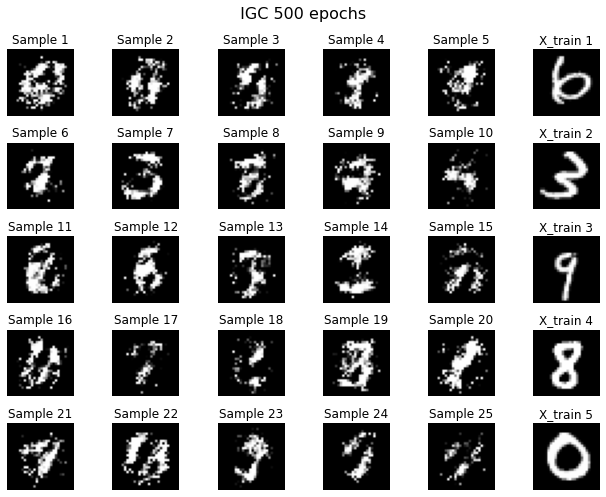

In [49]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle(" IGC 500 epochs ", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(samples_cdf_norm[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[i]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()

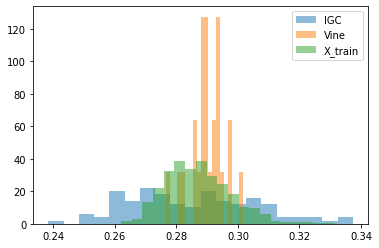

In [72]:
IGC_std_within = [np.std(samples_cdf[k].reshape(-1).detach().numpy()) for k in range(100)]
vine_std_within = [np.std(cop_sample[k].reshape(-1)) for k in range(25)]
X_train_std_within = [np.std(scs.norm.cdf(X_train[k].reshape(-1).detach().numpy())) for k in range(1000)]
plt.hist(IGC_std_within, bins=20, alpha=0.5, label='IGC',density=True)
plt.hist(vine_std_within, bins=20, alpha=0.5, label='Vine',density=True)
plt.hist(X_train_std_within, bins=20, alpha=0.5, label='X_train',density=True)
plt.legend()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_22764\3342878614.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = (torch.tensor(samples_cdf[i])).reshape(-1).numpy()


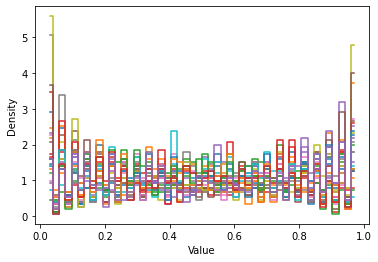

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

for i in range(25):
    data = (torch.tensor(samples_cdf[i])).reshape(-1).numpy()
    hist, bin_edges = np.histogram(data, bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.step(bin_centers, hist, where='mid', label=f'Histogram {i}')

plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Comparison of samples

In [3]:
def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

In [4]:
# load samples vine
samples_vine = np.load(f'copula_samples_mnist0_t50_scott.npy')
samples_vine = scs.norm.ppf(samples_vine)
# load samples ratio copula
samples_ratio = np.load(f'final_mnist_GGCNN\logsumexpGGCNN_HM100burnin_N01_9_500epoch_samples_mnist.npy')
#samples_ratio = np.load(f'logsumexpbigGGCNN_HM100burnin_N01_1_500epoch_samples_mnist.npy')

In [7]:
# sample from IGC

# load igc params
igc_cop = IGC(hidden_size=100, layers_number=3, output_size=28*28)
igc_cop.load_state_dict(torch.load('igc_cop_mnist_10runs_seed0.pth'))
samples_igc = igc_cop.forward_train(torch.randn((25, igc_cop.dim_latent))).detach().numpy()
samples_igc = scs.norm.ppf(samples_igc)

In [8]:
# sample from Gaussian
gauss_cov = np.cov(X_train.reshape(-1, 784).T)

samples_gauss = scs.multivariate_normal.rvs(size=(25), mean=np.zeros(784), cov=gauss_cov+1e-10*np.eye(784))


C:\Users\david\AppData\Local\Temp\ipykernel_24380\3934811080.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j%5 * 5 + i +100])).reshape(28, 28), cmap='gray')


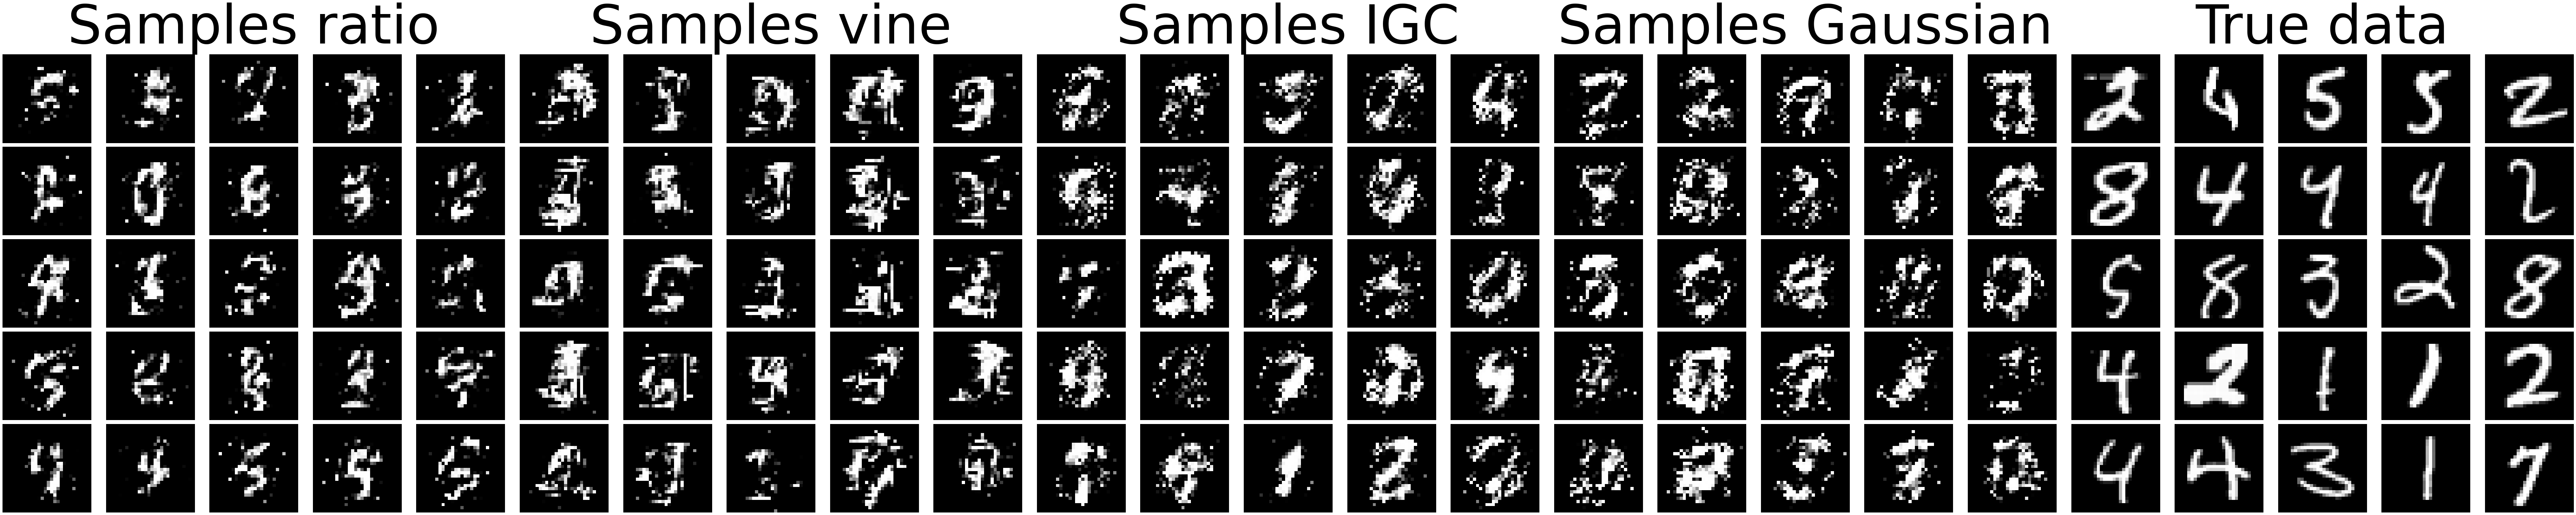

In [9]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(5, 25, figsize=(100, 20))
#fig.suptitle(" vine copula trc=50, thresh=0.05 train ", fontsize=16)

for i in range(5):
    for j in range(25):

        if j<5: # ratio copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_ratio[j%5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

            if (j%5)==2 and i==0:
                axes[i, j].set_title(f'Samples ratio',fontsize=150)

        if 4<j and j<10: # vine copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_vine[j%5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j%5)==2 and i==0:
                axes[i, j].set_title(f'Samples vine',fontsize=150)
        
        if 9<j and j<15: # igc copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_igc[j%5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j%5)==2 and i==0:
                axes[i, j].set_title(f'Samples IGC',fontsize=150)

        if 14<j and j<20: # Gaussian copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_gauss[j%5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j%5)==2 and i==0:
                axes[i, j].set_title(f'Samples Gaussian',fontsize=150)

        if 19<j: # true
            axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j%5 * 5 + i +100])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j%5)==2 and i==0:
                axes[i, j].set_title(f'True data',fontsize=150)

plt.tight_layout()
plt.show()

In [41]:
samples_vine.shape

(25, 784)

C:\Users\david\AppData\Local\Temp\ipykernel_24112\3070802243.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j % 5 * 5 + i + 100])).reshape(28, 28), cmap='gray')


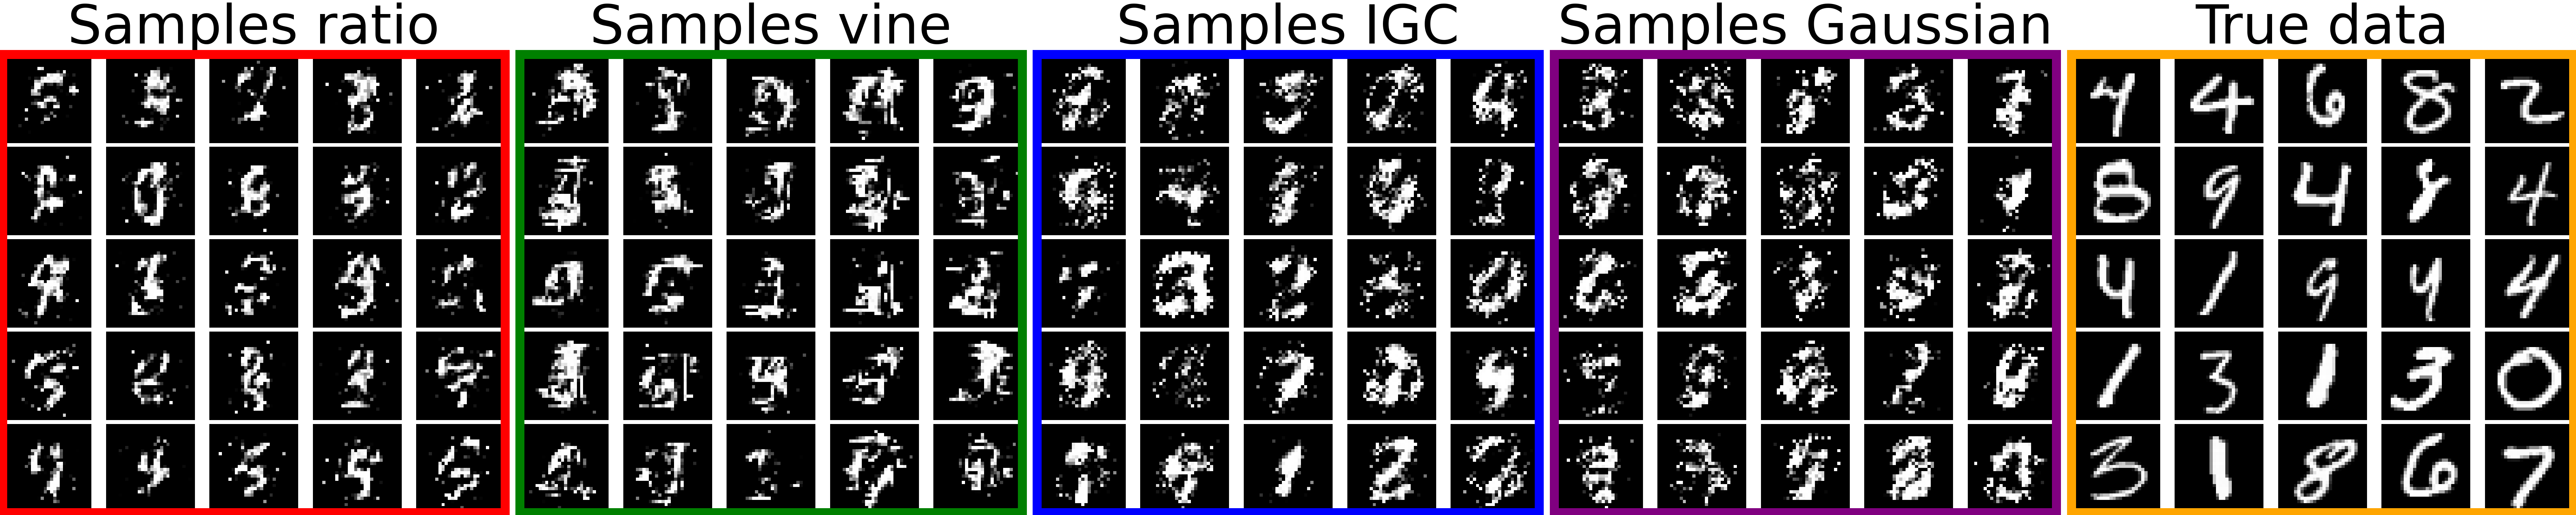

In [40]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# Create the subplot grid
fig, axes = plt.subplots(5, 25, figsize=(100, 20))

# Create a function to draw a rectangle around groups of subplots
def draw_subplot_box(fig, start_col, end_col, color):
    # Calculate the bounding box of the group of subplots
    pos0 = axes[0, start_col].get_position()
    pos1 = axes[-1, end_col].get_position()

    # Create a rectangle spanning from top-left to bottom-right of the group
    rect = Rectangle((pos0.x0, pos1.y0), pos1.x1 - pos0.x0, pos0.y1 - pos1.y0,
                     linewidth=25, edgecolor=color, facecolor='none')
    fig.add_artist(rect)

# Create the plots and add an outline for each group of 5x5 plots
for i in range(5):
    for j in range(25):
        if j < 5:  # ratio copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_ratio[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples ratio', fontsize=150)

        if 4 < j < 10:  # vine copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_vine[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples vine', fontsize=150)

        if 9 < j < 15:  # igc copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_igc[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples IGC', fontsize=150)

        if 14 < j < 20:  # Gaussian copula
            axes[i, j].imshow(reverse_transform(torch.tensor(samples_gauss[j % 5 * 5 + i])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'Samples Gaussian', fontsize=150)

        if j > 19:  # true data
            axes[i, j].imshow(reverse_transform(torch.tensor(X_test[j % 5 * 5 + i + 100])).reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
            if (j % 5) == 2 and i == 0:
                axes[i, j].set_title(f'True data', fontsize=150)

plt.tight_layout()
# Draw rectangles around the 5x5 blocks of subplots
draw_subplot_box(fig, start_col=0, end_col=4, color='red')       # Ratio Copula
draw_subplot_box(fig, start_col=5, end_col=9, color='green')     # Vine Copula
draw_subplot_box(fig, start_col=10, end_col=14, color='blue')    # IGC Copula
draw_subplot_box(fig, start_col=15, end_col=19, color='purple')  # Gaussian Copula
draw_subplot_box(fig, start_col=20, end_col=24, color='orange')  # True Data
plt.savefig('mnist_samples.png', bbox_inches='tight', dpi=300)
plt.show()
